<font size=5 color=black >
Paper reproduction project - Segnet - Group 26

## Our take on the Impact of Illumination-Invariant Image Pre-transformation for Contemporary Automotive Semantic Scene Understanding.

In 2018, <u>Naif Alshammari, Samet Akcay and Toby P. Breckon</u> published their paper <u>On the Impact of Illumination-Invariant Image Pre-transformation for Contemporary Automotive Semantic Scene Understanding.</u> The authors of this paper realized that illumination changes in outdoor environments under non-ideal weather conditions have a negative impact on automotive scene understanding and segmentation performance. The paper presents an evaluation of illumination-invariant image transforms on the <u>CamVid</u> dataset, to see if this improves the state of the art in scene understanding performance.

As part of TU Delft’s CS4240 Deep Learning course, we — Noureddine Begga, Hao Li and Zixuan Wan— attempt to give the reproduction of the results achieved in said paper a try. That is, we try to develop an implementation of the <u>Deep Fully Convolutional Neural Network SegNet</u> and preprocess the CamVid dataset with the illumination invariant image representation. More specifically, our goal is to achieve similar results as Table 1 of the paper (which is copied below).
![title](./report/1.png)
The Cambridge-driving Labeled Video Database (CamVid) is the first collection of videos with object class semantic labels, complete with metadata. The database provides ground truth labels that associate each pixel with one of 32 semantic classes.
![title](./report/2.png)

## What is a illumination invariant image representation?
An illumination invariant image representation is a colour representation computed from RGB that removes (or minimises) scene colour variations due to varying scene lighting conditions. This technique was introduced as an intrinsic image to represent the illumination invariant and intrinsic properties in the image [1] with illumination transforms generally computed with reference to the physical properties behind the capture and the presence of colour within the space. In most literature where a type of illumination invariance is applied had as an objective to remove shadows, and to improve scene classification and segmentation.
![title](./report/3.png)
For our reproduction we will implement two illumination invariance methods and compare these with the results of the authors. For our reproduction we will use the methods of Maddern et al.[2] and Alvarez et al.[3].

## illumination invariance method - Alvarez et al.
An illumination-invariant image 𝐼 is a single channel image calculated by combining the three RGB colour channels in the image 𝐼𝑅𝐺𝐵 ∈ {𝐼𝑅,𝐼𝐺,𝐼𝐵} . To compute the illumination invariant images, we use a single channel feature space 𝐼 combined with three linear sensors {𝑅,𝐺,𝐵} as follows for the method of Alvarez et al.:

$I_{\text {Alvarez}}=\cos (\theta) \log _{\text {approx}}\left(\frac{I_{R}}{I_{B}}\right)+\sin (\theta) \log _{\text {approx}}\left(\frac{I_{G}}{I_{B}}\right)$

Where 𝐼𝑅,𝐼𝐺,𝐼𝐵 are the tree RGB channels, 𝜃 ∈{0…180}, and 𝑙𝑜𝑔𝑎𝑝𝑝𝑟𝑜𝑥() is the logarithmic approximation for the division of two channels in an image 𝑥 ∈{𝑅,𝐺,𝐵}, which is computes as follows:

$\log _{\text {approx}(x)}=\propto\left(\left(x^{\frac{1}{\propto}}\right)-1\right)$

Where 𝑥 is the value from dividing the two channels and ∝ =5000. After evaluating images we decide projection angle 𝜃 = 135 degree.
## illumination invariance method - Maddern et al.
To compute the image for this method, we again convert the 3-channel floating point RGB image into corresponding illumination invariant image as follows:

$I_{\text {Maddern }}=0.5+\log \left(I_{G}\right)-\propto \log \left(I_{B}\right)-(1-\propto) \log \left(I_{R}\right)$

Where ∝ =0.48. This illumination-invariant approach was proposed to improve visual localization, mapping and scene classification for autonomous road vehicles.

Our results for image processing:
![title](./report/5.png)

## How will we evaluate the performance of using these illumination invariant image representations?
We will evaluate the performance of automotive scene understanding and segmentation using the SegNet [4] CNN architecture (Figure 3) with the two aforementioned illumination-invariant transformations.
![title](./report/4.png)
As mentioned before we will use the CamVid dataset with different pixel classes for the SegNet classification task (Figure 1 shows some examples). The authors of the paper used eleven classes: {sky, building, pole, road, pavement, tree, sign, fence, car, pedestrian, bicycle}. The dataset consists of 600 images in total, which we have divided into training, test and validation sets.

## Training the SegNet CNN model

The authors used a VGG16 [5] network pre-trained on the ImageNet [6] dataset, which is the encoder network within SegNet. An encoder network consists of convolution and pooling layers followed by a decoder network containing convolutional and upsampling layers. The authors have used Stochastic Gradient Descent (SGD) optimization, we however have chosen to use Adam optimization in the hopes of getting better results than the authors. Adam can be looked at as a combination of RMSprop and Stochastic Gradient Descent with momentum. It uses the squared gradients to scale the learning rate like RMSprop and it takes advantage of momentum by using moving average of the gradient instead of gradient itself like SGD with momentum[7]. We used the following hyperparameters: initial learning rate 1x10-3, no weight decay 5x10-4 and momentum 0.9. We train the model using the freely provided GPU from Google Colab. For training the neural network on the whole dataset, because of the computation capactiy, we downsized orginal images with scale ratio 0.1. The image resolution then become 72x96, which is 1/5 smaller than the original data. The amount of images for tain, test and validation sets are 447,58,196 respectively, which has approximate proportion of 0.6,0.1,0.3. Self-developed dataloder is used to separate, label processing and transform raw images.

## Code implementation

In [1]:
# Import Libraries
from __future__ import print_function
import shutil
import os
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import math
from collections import OrderedDict
import torch.nn.functional as F
import pprint
import torch.utils.data as data
import sys
sys.path.append('./')
import utils
import random

In [2]:
# Define dataloader class
class CamVid(data.Dataset):
    """CamVid dataset loader where the dataset is arranged as in
    https://github.com/alexgkendall/SegNet-Tutorial/tree/master/CamVid.
    Keyword arguments:
    - root_dir (``string``): Root directory path.
    - mode (``string``): The type of dataset: 'train' for training set, 'val'
    for validation set, and 'test' for test set.
    - transform (``callable``, optional): A function/transform that  takes in
    an PIL image and returns a transformed version. Default: None.
    - label_transform (``callable``, optional): A function/transform that takes
    in the target and transforms it. Default: None.
    - loader (``callable``, optional): A function to load an image given its
    path. By default ``default_loader`` is used.
    """
    # Training dataset root folders
    train_folder = 'train'
    train_lbl_folder = 'trainannot'

    # Validation dataset root folders
    val_folder = 'val'
    val_lbl_folder = 'valannot'

    # Test dataset root folders
    test_folder = 'test'
    test_lbl_folder = 'testannot'

    # Images extension
    img_extension = '.png'

    def __init__(self,
           root_dir,
           mode='train',
           transform=None,
           label_transform=None,
           loader=utils.pil_loader):
      
        self.root_dir = root_dir
        self.mode = mode
        self.transform = transform
        self.label_transform = label_transform
        self.loader = loader

        if self.mode.lower() == 'train':
            # Get the training data and labels filepaths
            self.train_data = utils.get_files(
                os.path.join(root_dir, self.train_folder),
                extension_filter=self.img_extension)

            self.train_labels = utils.get_files(
                os.path.join(root_dir, self.train_lbl_folder),
                extension_filter=self.img_extension)
        elif self.mode.lower() == 'val':
            # Get the validation data and labels filepaths
            self.val_data = utils.get_files(
                os.path.join(root_dir, self.val_folder),
                extension_filter=self.img_extension)

            self.val_labels = utils.get_files(
                os.path.join(root_dir, self.val_lbl_folder),
                extension_filter=self.img_extension)
        elif self.mode.lower() == 'test':
            # Get the test data and labels filepaths
            self.test_data = utils.get_files(
                os.path.join(root_dir, self.test_folder),
                extension_filter=self.img_extension)

            self.test_labels = utils.get_files(
                os.path.join(root_dir, self.test_lbl_folder),
                extension_filter=self.img_extension)
        else:
            raise RuntimeError("Unexpected dataset mode. "
                               "Supported modes are: train, val and test")
    
    def __getitem__(self, index):
        """
        Args:
        - index (``int``): index of the item in the dataset
        Returns:
        A tuple of ``PIL.Image`` (image, label) where label is the ground-truth
        of the image.
        """
        if self.mode.lower() == 'train':
            data_path, label_path = self.train_data[index], self.train_labels[
                index]
        elif self.mode.lower() == 'val':
            data_path, label_path = self.val_data[index], self.val_labels[
                index]
        elif self.mode.lower() == 'test':
            data_path, label_path = self.test_data[index], self.test_labels[
                index]
        else:
            raise RuntimeError("Unexpected dataset mode. "
                               "Supported modes are: train, val and test")

        img, label = self.loader(data_path, label_path)
        if self.transform is not None:
            img = self.transform(img)
            
        if self.label_transform is not None:
            label = self.label_transform(label)
        label = label.permute(1,2,0)*255
        label_np = label.numpy()
        label = rgb_to_label(label_np, colormap=color_encoding)
        label = torch.LongTensor(label)
        return img, label

    def __len__(self):
        """Returns the length of the dataset."""
        if self.mode.lower() == 'train':
            return len(self.train_data)
        elif self.mode.lower() == 'val':
            return len(self.val_data)
        elif self.mode.lower() == 'test':
            return len(self.test_data)
        else:
            raise RuntimeError("Unexpected dataset mode. "
                               "Supported modes are: train, val and test")

In [3]:
# Default encoding for pixel value, class name, and class color
class_name = {0: 'sky',
      1: 'building',
      2: 'pole',
      3: 'road_marking',
      4: 'road',
      5: 'pavement',
      6: 'tree',
      7: 'sign_symbol',
      8: 'fence',
      9: 'car',
      10: 'pedestrian',
      11: 'bicyclist',
      12: 'unlabeled'}


color_encoding = {0: (128, 128, 128),
      1: (128, 0, 0),
      2: (192, 192, 128),
      3: (255, 69, 0),
      4: (128, 64, 128),
      5: (60, 40, 222),
      6: (128, 128, 0),
      7: (192, 128, 128),
      8: (64, 64, 128),
      9: (64, 0, 128),
      10: (64, 64, 0),
      11: (0, 128, 192),
      12: (0, 0, 0)}

def rgb_to_label(rgb_image, colormap = color_encoding):
    '''Function to one hot encode RGB mask labels
        Inputs: 
            rgb_image - image matrix (eg. 256 x 256 x 3 dimension numpy ndarray)
            colormap - dictionary of color to label id
        Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
    '''
    num_classes = len(colormap)
    shape = rgb_image.shape[:2]
    encoded_image = np.zeros(shape,dtype=np.int8)
    for i, cls in enumerate(colormap):
        for x in range(encoded_image.shape[0]):
            for y in range (encoded_image.shape[1]):
                if(np.all(rgb_image[x][y] == colormap[i])):
                    encoded_image[x][y] = i
    return encoded_image


def label_to_rgb(label, colormap = color_encoding):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    output = np.zeros(label.shape[:2]+(3,))
    for k in colormap.keys():
        output[label==k] = colormap[k]
    return np.uint8(output)


112 66 20
torch.Size([4, 3, 72, 96])
torch.Size([4, 72, 96])


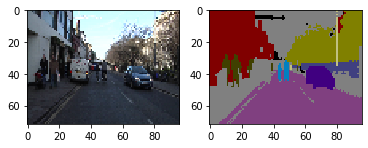

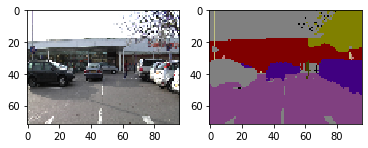

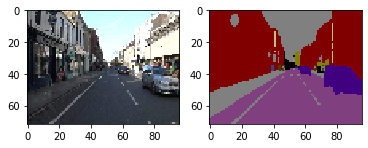

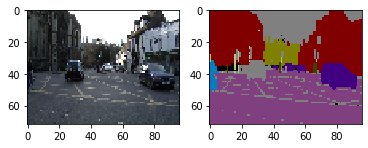

In [4]:
# Specify transforms using torchvision.transforms as transforms

res_ratio = 0.1 # set image size

transformations = transforms.Compose([
    transforms.Resize((int(res_ratio*720),int(res_ratio*960)),interpolation=Image.NEAREST), #set resolution with nearest neighbor interpolation
    transforms.ToTensor() # Normalize data to be of values [0-1]
])

train = CamVid('./','train',transformations, transformations)
val = CamVid('./','val',transformations, transformations)
test = CamVid('./','test',transformations, transformations)
train_dataloader = data.DataLoader(train, batch_size= 4, shuffle = True, num_workers=0)
val_dataloader = data.DataLoader(val, batch_size= 3, shuffle = True, num_workers=0)
test_dataloader = data.DataLoader(test, batch_size= 3, shuffle = True, num_workers=0)

print(len(train_dataloader), len(val_dataloader), len(test_dataloader))

for index,[img,label] in enumerate(train_dataloader):
    print(img.size())
    print(label.size())
    mask_encoded = [label_to_rgb(label[x,:,:].numpy(), color_encoding) for x in range(label.shape[0])]
    for i in range(0,4):
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(img[i].permute(1,2,0))
        plt.subplot(1,2,2)
        plt.imshow(mask_encoded[i])
    break

In [5]:
# SegNet Model - CNN


DEBUG = False


vgg16_dims = [
         (64, 64, 'M'),                             
         (128, 128, 'M'),                            
         (256, 256, 256,'M'),                          
         (512, 512, 512, 'M'),                         
         (512, 512, 512, 'M')                         
        ]

decoder_dims = [
          ('U', 512, 512, 512),                         
          ('U', 512, 512, 512),                         
          ('U', 256, 256, 256),                         
          ('U', 128, 128),                             
          ('U', 64, 64)                              
         ]


class SegNet(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(SegNet, self).__init__()

        self.input_channels = input_channels
        self.output_channels = output_channels

        self.vgg16 = models.vgg16(pretrained=True)


        # Encoder layers

        self.encoder_conv_00 = nn.Sequential(*[
                             nn.Conv2d(in_channels=self.input_channels,
                             out_channels=64,
                             kernel_size=3,
                             padding=1),
                             nn.BatchNorm2d(64)
                             ])
        self.encoder_conv_01 = nn.Sequential(*[
                             nn.Conv2d(in_channels=64,
                             out_channels=64,
                             kernel_size=3,
                             padding=1),
                             nn.BatchNorm2d(64)
                            ])
        self.encoder_conv_10 = nn.Sequential(*[
                             nn.Conv2d(in_channels=64,
                             out_channels=128,
                             kernel_size=3,
                             padding=1),
                             nn.BatchNorm2d(128)
                             ])
        self.encoder_conv_11 = nn.Sequential(*[
                             nn.Conv2d(in_channels=128,
                             out_channels=128,
                             kernel_size=3,
                             padding=1),
                             nn.BatchNorm2d(128)
                             ])
        self.encoder_conv_20 = nn.Sequential(*[
                             nn.Conv2d(in_channels=128,
                             out_channels=256,
                             kernel_size=3,
                             padding=1),
                             nn.BatchNorm2d(256)
                             ])
        self.encoder_conv_21 = nn.Sequential(*[
                             nn.Conv2d(in_channels=256,
                             out_channels=256,
                             kernel_size=3,
                             padding=1),
                             nn.BatchNorm2d(256)
                             ])
        self.encoder_conv_22 = nn.Sequential(*[
                             nn.Conv2d(in_channels=256,
                             out_channels=256,
                             kernel_size=3,
                             padding=1),
                             nn.BatchNorm2d(256)
                             ])
        self.encoder_conv_30 = nn.Sequential(*[
                             nn.Conv2d(in_channels=256,
                             out_channels=512,
                             kernel_size=3,
                             padding=1),
                             nn.BatchNorm2d(512)
                             ])
        self.encoder_conv_31 = nn.Sequential(*[
                             nn.Conv2d(in_channels=512,
                             out_channels=512,
                             kernel_size=3,
                             padding=1),
                             nn.BatchNorm2d(512)
                             ])
        self.encoder_conv_32 = nn.Sequential(*[
                             nn.Conv2d(in_channels=512,
                             out_channels=512,
                             kernel_size=3,
                             padding=1),
                             nn.BatchNorm2d(512)
                             ])
        self.encoder_conv_40 = nn.Sequential(*[
                             nn.Conv2d(in_channels=512,
                             out_channels=512,
                             kernel_size=3,
                             padding=1),
                             nn.BatchNorm2d(512)
                             ])
        self.encoder_conv_41 = nn.Sequential(*[
                             nn.Conv2d(in_channels=512,
                             out_channels=512,
                             kernel_size=3,
                             padding=1),
                             nn.BatchNorm2d(512)
                             ])
        self.encoder_conv_42 = nn.Sequential(*[
                             nn.Conv2d(in_channels=512,
                             out_channels=512,
                             kernel_size=3,
                             padding=1),
                             nn.BatchNorm2d(512)
                             ])

        self.init_vgg_weigts()

        # Decoder layers

        self.decoder_convtr_42 = nn.Sequential(*[
                              nn.ConvTranspose2d(in_channels=512,
                              out_channels=512,
                              kernel_size=3,
                              padding=1),
                              nn.BatchNorm2d(512)
                              ])
        self.decoder_convtr_41 = nn.Sequential(*[
                              nn.ConvTranspose2d(in_channels=512,
                              out_channels=512,
                              kernel_size=3,
                              padding=1),
                              nn.BatchNorm2d(512)
                              ])
        self.decoder_convtr_40 = nn.Sequential(*[
                              nn.ConvTranspose2d(in_channels=512,
                              out_channels=512,
                              kernel_size=3,
                              padding=1),
                              nn.BatchNorm2d(512)
                              ])
        self.decoder_convtr_32 = nn.Sequential(*[
                              nn.ConvTranspose2d(in_channels=512,
                              out_channels=512,
                              kernel_size=3,
                              padding=1),
                              nn.BatchNorm2d(512)
                              ])
        self.decoder_convtr_31 = nn.Sequential(*[
                              nn.ConvTranspose2d(in_channels=512,
                              out_channels=512,
                              kernel_size=3,
                              padding=1),
                              nn.BatchNorm2d(512)
                              ])
        self.decoder_convtr_30 = nn.Sequential(*[
                              nn.ConvTranspose2d(in_channels=512,
                              out_channels=256,
                              kernel_size=3,
                              padding=1),
                              nn.BatchNorm2d(256)
                              ])
        self.decoder_convtr_22 = nn.Sequential(*[
                              nn.ConvTranspose2d(in_channels=256,
                              out_channels=256,
                              kernel_size=3,
                              padding=1),
                              nn.BatchNorm2d(256)
                              ])
        self.decoder_convtr_21 = nn.Sequential(*[
                              nn.ConvTranspose2d(in_channels=256,
                              out_channels=256,
                              kernel_size=3,
                              padding=1),
                              nn.BatchNorm2d(256)
                              ])
        self.decoder_convtr_20 = nn.Sequential(*[
                              nn.ConvTranspose2d(in_channels=256,
                              out_channels=128,
                              kernel_size=3,
                              padding=1),
                              nn.BatchNorm2d(128)
                              ])
        self.decoder_convtr_11 = nn.Sequential(*[
                              nn.ConvTranspose2d(in_channels=128,
                              out_channels=128,
                              kernel_size=3,
                              padding=1),
                              nn.BatchNorm2d(128)
                              ])
        self.decoder_convtr_10 = nn.Sequential(*[
                              nn.ConvTranspose2d(in_channels=128,
                              out_channels=64,
                              kernel_size=3,
                              padding=1),
                              nn.BatchNorm2d(64)
                              ])
        self.decoder_convtr_01 = nn.Sequential(*[
                              nn.ConvTranspose2d(in_channels=64,
                              out_channels=64,
                              kernel_size=3,
                              padding=1),
                              nn.BatchNorm2d(64)
                              ])
        self.decoder_convtr_00 = nn.Sequential(*[
                              nn.ConvTranspose2d(in_channels=64,
                              out_channels=self.output_channels,
                              kernel_size=3,
                              padding=1)
                              ])


    def forward(self, input_img):
        """
        Forward pass `input_img` through the network
        """

        # Encoder

        # Encoder Stage - 1
        dim_0 = input_img.size()
        x_00 = F.relu(self.encoder_conv_00(input_img))
        x_01 = F.relu(self.encoder_conv_01(x_00))
        x_0, indices_0 = F.max_pool2d(x_01, kernel_size=2, stride=2, return_indices=True)

        # Encoder Stage - 2
        dim_1 = x_0.size()
        x_10 = F.relu(self.encoder_conv_10(x_0))
        x_11 = F.relu(self.encoder_conv_11(x_10))
        x_1, indices_1 = F.max_pool2d(x_11, kernel_size=2, stride=2, return_indices=True)

        # Encoder Stage - 3
        dim_2 = x_1.size()
        x_20 = F.relu(self.encoder_conv_20(x_1))
        x_21 = F.relu(self.encoder_conv_21(x_20))
        x_22 = F.relu(self.encoder_conv_22(x_21))
        x_2, indices_2 = F.max_pool2d(x_22, kernel_size=2, stride=2, return_indices=True)

        # Encoder Stage - 4
        dim_3 = x_2.size()
        x_30 = F.relu(self.encoder_conv_30(x_2))
        x_31 = F.relu(self.encoder_conv_31(x_30))
        x_32 = F.relu(self.encoder_conv_32(x_31))
        x_3, indices_3 = F.max_pool2d(x_32, kernel_size=2, stride=2, return_indices=True)

        # Encoder Stage - 5
        dim_4 = x_3.size()
        x_40 = F.relu(self.encoder_conv_40(x_3))
        x_41 = F.relu(self.encoder_conv_41(x_40))
        x_42 = F.relu(self.encoder_conv_42(x_41))
        x_4, indices_4 = F.max_pool2d(x_42, kernel_size=2, stride=2, return_indices=True)

        # Decoder

        dim_d = x_4.size()

        # Decoder Stage - 5
        x_4d = F.max_unpool2d(x_4, indices_4, kernel_size=2, stride=2, output_size=dim_4)
        x_42d = F.relu(self.decoder_convtr_42(x_4d))
        x_41d = F.relu(self.decoder_convtr_41(x_42d))
        x_40d = F.relu(self.decoder_convtr_40(x_41d))
        dim_4d = x_40d.size()

        # Decoder Stage - 4
        x_3d = F.max_unpool2d(x_40d, indices_3, kernel_size=2, stride=2, output_size=dim_3)
        x_32d = F.relu(self.decoder_convtr_32(x_3d))
        x_31d = F.relu(self.decoder_convtr_31(x_32d))
        x_30d = F.relu(self.decoder_convtr_30(x_31d))
        dim_3d = x_30d.size()

        # Decoder Stage - 3
        x_2d = F.max_unpool2d(x_30d, indices_2, kernel_size=2, stride=2, output_size=dim_2)
        x_22d = F.relu(self.decoder_convtr_22(x_2d))
        x_21d = F.relu(self.decoder_convtr_21(x_22d))
        x_20d = F.relu(self.decoder_convtr_20(x_21d))
        dim_2d = x_20d.size()

        # Decoder Stage - 2
        x_1d = F.max_unpool2d(x_20d, indices_1, kernel_size=2, stride=2, output_size=dim_1)
        x_11d = F.relu(self.decoder_convtr_11(x_1d))
        x_10d = F.relu(self.decoder_convtr_10(x_11d))
        dim_1d = x_10d.size()

        # Decoder Stage - 1
        x_0d = F.max_unpool2d(x_10d, indices_0, kernel_size=2, stride=2, output_size=dim_0)
        x_01d = F.relu(self.decoder_convtr_01(x_0d))
        x_00d = self.decoder_convtr_00(x_01d)
        dim_0d = x_00d.size()

        x_softmax = F.softmax(x_00d, dim=1)


        if DEBUG:
            print("dim_0: {}".format(dim_0))
            print("dim_1: {}".format(dim_1))
            print("dim_2: {}".format(dim_2))
            print("dim_3: {}".format(dim_3))
            print("dim_4: {}".format(dim_4))

            print("dim_d: {}".format(dim_d))
            print("dim_4d: {}".format(dim_4d))
            print("dim_3d: {}".format(dim_3d))
            print("dim_2d: {}".format(dim_2d))
            print("dim_1d: {}".format(dim_1d))
            print("dim_0d: {}".format(dim_0d))


        return x_00d, x_softmax


    def init_vgg_weigts(self):
        assert self.encoder_conv_00[0].weight.size() == self.vgg16.features[0].weight.size()
        self.encoder_conv_00[0].weight.data = self.vgg16.features[0].weight.data
        assert self.encoder_conv_00[0].bias.size() == self.vgg16.features[0].bias.size()
        self.encoder_conv_00[0].bias.data = self.vgg16.features[0].bias.data

        assert self.encoder_conv_01[0].weight.size() == self.vgg16.features[2].weight.size()
        self.encoder_conv_01[0].weight.data = self.vgg16.features[2].weight.data
        assert self.encoder_conv_01[0].bias.size() == self.vgg16.features[2].bias.size()
        self.encoder_conv_01[0].bias.data = self.vgg16.features[2].bias.data

        assert self.encoder_conv_10[0].weight.size() == self.vgg16.features[5].weight.size()
        self.encoder_conv_10[0].weight.data = self.vgg16.features[5].weight.data
        assert self.encoder_conv_10[0].bias.size() == self.vgg16.features[5].bias.size()
        self.encoder_conv_10[0].bias.data = self.vgg16.features[5].bias.data

        assert self.encoder_conv_11[0].weight.size() == self.vgg16.features[7].weight.size()
        self.encoder_conv_11[0].weight.data = self.vgg16.features[7].weight.data
        assert self.encoder_conv_11[0].bias.size() == self.vgg16.features[7].bias.size()
        self.encoder_conv_11[0].bias.data = self.vgg16.features[7].bias.data

        assert self.encoder_conv_20[0].weight.size() == self.vgg16.features[10].weight.size()
        self.encoder_conv_20[0].weight.data = self.vgg16.features[10].weight.data
        assert self.encoder_conv_20[0].bias.size() == self.vgg16.features[10].bias.size()
        self.encoder_conv_20[0].bias.data = self.vgg16.features[10].bias.data

        assert self.encoder_conv_21[0].weight.size() == self.vgg16.features[12].weight.size()
        self.encoder_conv_21[0].weight.data = self.vgg16.features[12].weight.data
        assert self.encoder_conv_21[0].bias.size() == self.vgg16.features[12].bias.size()
        self.encoder_conv_21[0].bias.data = self.vgg16.features[12].bias.data

        assert self.encoder_conv_22[0].weight.size() == self.vgg16.features[14].weight.size()
        self.encoder_conv_22[0].weight.data = self.vgg16.features[14].weight.data
        assert self.encoder_conv_22[0].bias.size() == self.vgg16.features[14].bias.size()
        self.encoder_conv_22[0].bias.data = self.vgg16.features[14].bias.data

        assert self.encoder_conv_30[0].weight.size() == self.vgg16.features[17].weight.size()
        self.encoder_conv_30[0].weight.data = self.vgg16.features[17].weight.data
        assert self.encoder_conv_30[0].bias.size() == self.vgg16.features[17].bias.size()
        self.encoder_conv_30[0].bias.data = self.vgg16.features[17].bias.data

        assert self.encoder_conv_31[0].weight.size() == self.vgg16.features[19].weight.size()
        self.encoder_conv_31[0].weight.data = self.vgg16.features[19].weight.data
        assert self.encoder_conv_31[0].bias.size() == self.vgg16.features[19].bias.size()
        self.encoder_conv_31[0].bias.data = self.vgg16.features[19].bias.data

        assert self.encoder_conv_32[0].weight.size() == self.vgg16.features[21].weight.size()
        self.encoder_conv_32[0].weight.data = self.vgg16.features[21].weight.data
        assert self.encoder_conv_32[0].bias.size() == self.vgg16.features[21].bias.size()
        self.encoder_conv_32[0].bias.data = self.vgg16.features[21].bias.data

        assert self.encoder_conv_40[0].weight.size() == self.vgg16.features[24].weight.size()
        self.encoder_conv_40[0].weight.data = self.vgg16.features[24].weight.data
        assert self.encoder_conv_40[0].bias.size() == self.vgg16.features[24].bias.size()
        self.encoder_conv_40[0].bias.data = self.vgg16.features[24].bias.data

        assert self.encoder_conv_41[0].weight.size() == self.vgg16.features[26].weight.size()
        self.encoder_conv_41[0].weight.data = self.vgg16.features[26].weight.data
        assert self.encoder_conv_41[0].bias.size() == self.vgg16.features[26].bias.size()
        self.encoder_conv_41[0].bias.data = self.vgg16.features[26].bias.data

        assert self.encoder_conv_42[0].weight.size() == self.vgg16.features[28].weight.size()
        self.encoder_conv_42[0].weight.data = self.vgg16.features[28].weight.data
        assert self.encoder_conv_42[0].bias.size() == self.vgg16.features[28].bias.size()
        self.encoder_conv_42[0].bias.data = self.vgg16.features[28].bias.data


<font size=5 color=black >
Test for a single image

In [6]:
# Extract a single image and mask
for index,[img,label] in enumerate(train_dataloader):
    x = img
    y = label
    break

In [87]:

"""
Train a SegNet model
Usage:
python train.py --data_root /home/SharedData/intern_sayan/PascalVOC2012/data/VOCdevkit/VOC2012/ \
                --train_path ImageSets/Segmentation/train.txt \
                --img_dir JPEGImages \
                --mask_dir SegmentationClass \
                --save_dir /home/SharedData/intern_sayan/PascalVOC2012/ \
                --checkpoint /home/SharedData/intern_sayan/PascalVOC2012/model_best.pth \
                --gpu 1
"""

from __future__ import print_function
import os
import time
import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable



# Parameters
NUM_INPUT_CHANNELS = 3
NUM_OUTPUT_CHANNELS = 13

NUM_EPOCHS = 200

LEARNING_RATE = 1e-3
MOMENTUM = 0.9
BATCH_SIZE = 4



def train():
    is_better = True
    prev_loss = float('inf')
#     for continue learning
#     model.load_state_dict(torch.load("./model_best.pth"))
    model.train()
    
    loss_list = []
    acc_list = []
    for epoch in range(NUM_EPOCHS):
        loss_f = 0
        t_start = time.time()


        input_tensor = Variable(x)
        target_tensor = Variable(y)
        if CUDA:
            input_tensor = input_tensor.cuda()
            target_tensor = target_tensor.cuda()

        predicted_tensor, softmaxed_tensor = model(input_tensor)


        optimizer.zero_grad()
        loss = criterion(predicted_tensor, target_tensor)
        loss.backward()
        optimizer.step()
        

        loss_f += loss.float()
        
        _, prediction = torch.max(predicted_tensor,1)
        y_true = torch.flatten(target_tensor)
        y_prep = torch.flatten(prediction)
        intersection = torch.sum(y_true * y_prep)
        acc = (2. * intersection) / (torch.sum(y_true*y_true) + torch.sum(y_prep*y_prep))
        acc = acc.detach().cpu().numpy()
        acc_list.append(acc)
        
        delta = time.time() - t_start
        is_better = loss_f < prev_loss
        loss_list.append(loss_f/len(x))
        if is_better:
            prev_loss = loss_f
        torch.save(model.state_dict(), os.path.join('./', "model_best.pth"))
        
        print("Epoch #{}\tLoss: {:.8f}\t Time: {:2f}s".format(epoch+1, loss_f, delta))
    return loss_list, acc_list

if __name__ == "__main__":


    CUDA = torch.cuda.is_available()

    print(CUDA)
    # train_dataloader = data.DataLoader(train, batch_size=4, shuffle = True, num_workers=4)

    # weights when using median frequency balancing used in SegNet paper
    # https://arxiv.org/pdf/1511.00561.pdf
    # The numbers were generated by:
    # https://github.com/yandex/segnet-torch/blob/master/datasets/camvid-gen.lua
    CAMVID_CLASS_WEIGHTS = [0.58872014284134,
                 0.51052379608154,
                 2.6966278553009,
                 0.45021694898605,
                 1.1785038709641,
                 0.77028578519821,
                 2.4782588481903,
                 2.5273461341858,
                 1.0122526884079,
                 3.2375309467316,
                 4.1312313079834,
                 0.3,
                 0]
    if CUDA:
        model = SegNet(input_channels=NUM_INPUT_CHANNELS, output_channels=NUM_OUTPUT_CHANNELS).cuda()
        class_weights = torch.FloatTensor(CAMVID_CLASS_WEIGHTS).cuda()
        criterion = torch.nn.CrossEntropyLoss(weight=class_weights).cuda()
    else:
        model = SegNet(input_channels=NUM_INPUT_CHANNELS, output_channels=NUM_OUTPUT_CHANNELS)
        class_weights = torch.FloatTensor(CAMVID_CLASS_WEIGHTS)
        criterion = torch.nn.CrossEntropyLoss(weight=class_weights)


    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    loss_list = []
    acc_list = []
    loss_list, acc_list = train()

True
Epoch #1	Loss: 2.55754876	 Time: 0.096742s
Epoch #2	Loss: 2.32248020	 Time: 0.084774s
Epoch #3	Loss: 1.91855991	 Time: 0.079787s
Epoch #4	Loss: 1.53522611	 Time: 0.081776s
Epoch #5	Loss: 1.23839629	 Time: 0.083776s
Epoch #6	Loss: 1.08583093	 Time: 0.081781s
Epoch #7	Loss: 0.95990711	 Time: 0.078834s
Epoch #8	Loss: 0.84045833	 Time: 0.078817s
Epoch #9	Loss: 0.74290419	 Time: 0.082778s
Epoch #10	Loss: 0.65871602	 Time: 0.080783s
Epoch #11	Loss: 0.60670245	 Time: 0.080816s
Epoch #12	Loss: 0.55186510	 Time: 0.083745s
Epoch #13	Loss: 0.47650722	 Time: 0.079786s
Epoch #14	Loss: 0.45593768	 Time: 0.078789s
Epoch #15	Loss: 0.39415997	 Time: 0.077837s
Epoch #16	Loss: 0.37400636	 Time: 0.081813s
Epoch #17	Loss: 0.33640644	 Time: 0.079787s
Epoch #18	Loss: 0.31342551	 Time: 0.081816s
Epoch #19	Loss: 0.29602915	 Time: 0.086768s
Epoch #20	Loss: 0.27636454	 Time: 0.083809s
Epoch #21	Loss: 0.25970283	 Time: 0.081781s
Epoch #22	Loss: 0.24345094	 Time: 0.082803s
Epoch #23	Loss: 0.22949116	 Time: 0.

Epoch #186	Loss: 0.00174336	 Time: 0.080817s
Epoch #187	Loss: 0.00172666	 Time: 0.082813s
Epoch #188	Loss: 0.00170992	 Time: 0.077755s
Epoch #189	Loss: 0.00169344	 Time: 0.080758s
Epoch #190	Loss: 0.00167738	 Time: 0.077791s
Epoch #191	Loss: 0.00166144	 Time: 0.079785s
Epoch #192	Loss: 0.00164748	 Time: 0.083792s
Epoch #193	Loss: 0.00163225	 Time: 0.080816s
Epoch #194	Loss: 0.00161725	 Time: 0.081782s
Epoch #195	Loss: 0.00160575	 Time: 0.086760s
Epoch #196	Loss: 0.00159144	 Time: 0.083777s
Epoch #197	Loss: 0.00157649	 Time: 0.080752s
Epoch #198	Loss: 0.00156168	 Time: 0.087765s
Epoch #199	Loss: 0.00154735	 Time: 0.082826s
Epoch #200	Loss: 0.00153315	 Time: 0.077825s


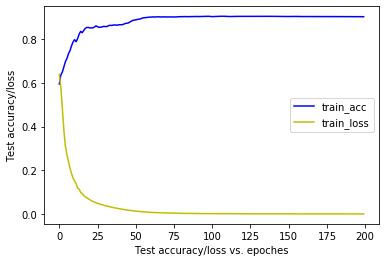

In [97]:
# Learning curve
x1 = range(0, NUM_EPOCHS)
y1 = acc_list
plt.figure
plt.plot(x1, y1, 'b-', label="train_acc")
plt.xlabel('Test accuracy/loss vs. epoches')
plt.ylabel('Test accuracy/loss')
x2 = range(0, NUM_EPOCHS)
y2 = loss_list
plt.plot(x2, y2, 'y-', label="train_loss")
plt.legend(loc="center right")
plt.show()


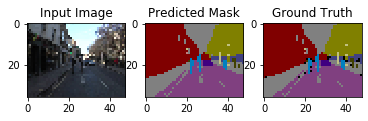

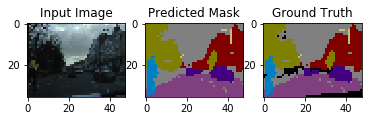

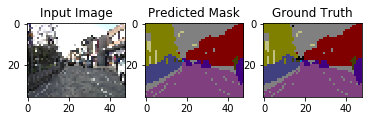

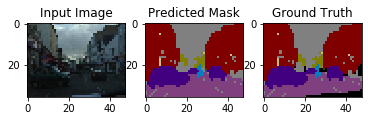

In [27]:
# test

SAVED_MODEL_PATH = "./model_best.pth"
OUTPUT_DIR = "./result_image"

def validate():
    model.eval()

    input_tensor = torch.autograd.Variable(x)
    target_tensor = torch.autograd.Variable(y)

    if CUDA:
        input_tensor = input_tensor.cuda()
        target_tensor = target_tensor.cuda()

    predicted_tensor, softmaxed_tensor = model(input_tensor)
    loss = criterion(predicted_tensor, target_tensor)
    
    for idx, predicted_mask in enumerate(softmaxed_tensor):
        
        target_mask = target_tensor[idx]
        input_image = input_tensor[idx]
        fig = plt.figure()

        a = fig.add_subplot(1,3,1)
        plt.imshow(input_image.cpu().permute(1,2,0))
        a.set_title('Input Image')

        a = fig.add_subplot(1,3,2)
        predicted_mx = predicted_mask.detach().cpu().numpy()
        predicted_mx = predicted_mx.argmax(axis=0)
        predicted_rgb = label_to_rgb(predicted_mx, color_encoding)
        plt.imshow(predicted_rgb)
        a.set_title('Predicted Mask')

        a = fig.add_subplot(1,3,3)
        target_mx = target_mask.detach().cpu().numpy()
        target_rgb = label_to_rgb(target_mx, color_encoding)
        plt.imshow(target_rgb)
        a.set_title('Ground Truth')


if __name__ == "__main__":

    CUDA = torch.cuda.is_available()

    if CUDA:
        model = SegNet(input_channels=NUM_INPUT_CHANNELS,
                       output_channels=NUM_OUTPUT_CHANNELS).cuda()

        class_weights = torch.FloatTensor(CAMVID_CLASS_WEIGHTS).cuda()
        criterion = torch.nn.CrossEntropyLoss(weight=class_weights).cuda()
    else:
        model = SegNet(input_channels=NUM_INPUT_CHANNELS,
                       output_channels=NUM_OUTPUT_CHANNELS)

        class_weights = torch.FloatTensor(CAMVID_CLASS_WEIGHTS).cuda()
        criterion = torch.nn.CrossEntropyLoss(weight=class_weights)


    model.load_state_dict(torch.load(SAVED_MODEL_PATH))


    validate()


<font size=5 color=black >
Test for whole dataset

In [8]:
"""
Train a SegNet model
Usage:
python train.py --data_root /home/SharedData/intern_sayan/PascalVOC2012/data/VOCdevkit/VOC2012/ \
                --train_path ImageSets/Segmentation/train.txt \
                --img_dir JPEGImages \
                --mask_dir SegmentationClass \
                --save_dir /home/SharedData/intern_sayan/PascalVOC2012/ \
                --checkpoint /home/SharedData/intern_sayan/PascalVOC2012/model_best.pth \
                --gpu 1
"""

from __future__ import print_function
import os
import time
import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable



# Parameters
NUM_INPUT_CHANNELS = 3
NUM_OUTPUT_CHANNELS = 13

NUM_EPOCHS = 160

LEARNING_RATE = 1e-3
MOMENTUM = 0.9
BATCH_SIZE = 4



def train():
    is_better = True
    prev_loss = float('inf')
#     model.load_state_dict(torch.load("./model_best.pth"))
    model.train()
    
    loss_list = []
    acc_list = []
    for epoch in range(NUM_EPOCHS):
        loss_f = 0
        t_start = time.time()

        for index,[img,label] in enumerate(train_dataloader):
            input_tensor = Variable(img)
            target_tensor = Variable(label)
            if CUDA:
                input_tensor = input_tensor.cuda()
                target_tensor = target_tensor.cuda()

            predicted_tensor, softmaxed_tensor = model(input_tensor)


            optimizer.zero_grad()
            loss = criterion(predicted_tensor, target_tensor)
            loss.backward()
            optimizer.step()


            loss_f += loss.float()
            

            delta = time.time() - t_start
            is_better = loss_f < prev_loss

            if is_better:
                prev_loss = loss_f
            if index%40== 0:
                print("Epoch #{}\tTotal loss: {:.8f}\t Time: {:2f}s".format(epoch+1, loss_f , delta))
            if index == (len(train_dataloader) - 1):
                loss_list.append(loss_f)
                _, prediction = torch.max(predicted_tensor,1)
                y_true = torch.flatten(target_tensor)
                y_prep = torch.flatten(prediction)
                intersection = torch.sum(y_true * y_prep)
                acc = (2. * intersection) / (torch.sum(y_true*y_true) + torch.sum(y_prep*y_prep))
                acc = acc.detach().cpu().numpy()
                acc_list.append(acc)
        torch.save(model.state_dict(), os.path.join('/content/drive/My Drive/segnet', "model_best.pth"))
    return loss_list,acc_list

if __name__ == "__main__":


    CUDA = torch.cuda.is_available()


    # weights when using median frequency balancing used in SegNet paper
    # https://arxiv.org/pdf/1511.00561.pdf
    # The numbers were generated by:
    # https://github.com/yandex/segnet-torch/blob/master/datasets/camvid-gen.lua
    CAMVID_CLASS_WEIGHTS = [0.58872014284134,
                 0.51052379608154,
                 2.6966278553009,
                 0.45021694898605,
                 1.1785038709641,
                 0.77028578519821,
                 2.4782588481903,
                 2.5273461341858,
                 1.0122526884079,
                 3.2375309467316,
                 4.1312313079834,
                 0.3,
                 0]
    if CUDA:
        model = SegNet(input_channels=NUM_INPUT_CHANNELS, output_channels=NUM_OUTPUT_CHANNELS).cuda()
        class_weights = torch.FloatTensor(CAMVID_CLASS_WEIGHTS).cuda()
        criterion = torch.nn.CrossEntropyLoss(weight=class_weights).cuda()
    else:
        model = SegNet(input_channels=NUM_INPUT_CHANNELS, output_channels=NUM_OUTPUT_CHANNELS)
        class_weights = torch.FloatTensor(CAMVID_CLASS_WEIGHTS)
        criterion = torch.nn.CrossEntropyLoss(weight=class_weights)


    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    loss_list = []
    acc_list = []
    loss_list, acc_list= train()

Epoch #1	Total loss: 2.79073524	 Time: 3.158261s
Epoch #1	Total loss: 52.70711517	 Time: 120.173725s
Epoch #1	Total loss: 88.79529572	 Time: 225.196719s
Epoch #2	Total loss: 0.89505726	 Time: 0.196335s
Epoch #2	Total loss: 34.81172180	 Time: 8.891248s
Epoch #2	Total loss: 67.23095703	 Time: 17.123669s
Epoch #3	Total loss: 0.66244602	 Time: 0.206405s
Epoch #3	Total loss: 30.05274200	 Time: 7.692185s
Epoch #3	Total loss: 57.62046814	 Time: 15.973802s
Epoch #4	Total loss: 0.74270427	 Time: 0.294773s
Epoch #4	Total loss: 28.73457336	 Time: 7.664445s
Epoch #4	Total loss: 55.50716400	 Time: 15.843583s
Epoch #5	Total loss: 0.51564145	 Time: 0.194166s
Epoch #5	Total loss: 25.89620972	 Time: 7.567474s
Epoch #5	Total loss: 51.41121674	 Time: 15.462481s
Epoch #6	Total loss: 0.64950240	 Time: 0.193268s
Epoch #6	Total loss: 27.27328300	 Time: 7.767581s
Epoch #6	Total loss: 54.92087936	 Time: 15.842180s
Epoch #7	Total loss: 0.48998925	 Time: 0.186098s
Epoch #7	Total loss: 26.42895889	 Time: 7.957027

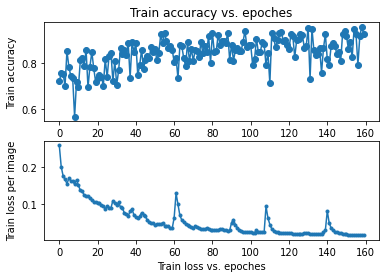

In [10]:
x1 = range(0, NUM_EPOCHS)
y1 = acc_list
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('Train accuracy vs. epoches')
plt.ylabel('Train accuracy')
x2 = range(0, NUM_EPOCHS)
y2 = np.array(loss_list)/(len(train_dataloader)*4)


plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('Train loss vs. epoches')
plt.ylabel('Train loss per image')
plt.show()
# 

Processd #1 batch out of 1/8
Processd #2 batch out of 2/8
Processd #3 batch out of 3/8
Processd #4 batch out of 4/8
Processd #5 batch out of 5/8
Processd #6 batch out of 6/8
Processd #7 batch out of 7/8
Processd #8 batch out of 8/8
Processd #9 batch out of 9/8
Visualize the result for 3 images in last batch


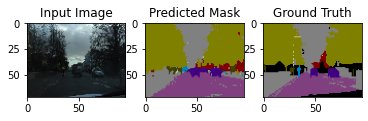

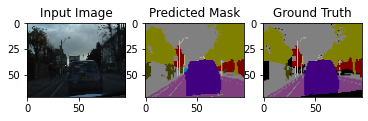

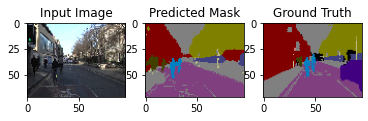

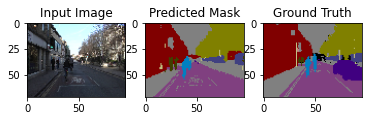

In [11]:
# test
SAVED_MODEL_PATH = "/content/drive/My Drive/segnet/model_best.pth"
OUTPUT_DIR = "/content/drive/My Drive/segnet/result_image"


# Parameters
NUM_INPUT_CHANNELS = 3
NUM_OUTPUT_CHANNELS = 13

MOMENTUM = 0.9
BATCH_SIZE = 4
CAMVID_CLASS_WEIGHTS = [0.58872014284134,
                 0.51052379608154,
                 2.6966278553009,
                 0.45021694898605,
                 1.1785038709641,
                 0.77028578519821,
                 2.4782588481903,
                 2.5273461341858,
                 1.0122526884079,
                 3.2375309467316,
                 4.1312313079834,
                 0.3,
                 0]
def validate():
    model.eval()
    acc_list_val = []
    loss_list_val = []
    for batch_idx,[img,label] in enumerate(val_dataloader):
        input_tensor = torch.autograd.Variable(img)
        target_tensor = torch.autograd.Variable(label)

        if CUDA:
            input_tensor = input_tensor.cuda()
            target_tensor = target_tensor.cuda()

        predicted_tensor, softmaxed_tensor = model(input_tensor)
        loss = criterion(predicted_tensor, target_tensor)
        loss_list_val.append(loss.float())
        
        _, prediction = torch.max(predicted_tensor,1)
        y_true = torch.flatten(target_tensor)
        y_prep = torch.flatten(prediction)
        intersection = torch.sum(y_true * y_prep)
        acc = (2. * intersection) / (torch.sum(y_true*y_true) + torch.sum(y_prep*y_prep))
        acc = acc.detach().cpu().numpy()
        acc_list_val.append(acc)
        print("Processd #{} batch out of {}/{}".format(batch_idx+1, batch_idx+1, 8))
              
        if batch_idx == 8:
            print("Visualize the result for 3 images in last batch")
            for idx, predicted_mask in enumerate(softmaxed_tensor):

                target_mask = target_tensor[idx]
                input_image = input_tensor[idx]
                fig = plt.figure()

                a = fig.add_subplot(1,3,1)
                plt.imshow(input_image.cpu().permute(1,2,0))
                a.set_title('Input Image')

                a = fig.add_subplot(1,3,2)
                predicted_mx = predicted_mask.detach().cpu().numpy()
                predicted_mx = predicted_mx.argmax(axis=0)
                predicted_rgb = label_to_rgb(predicted_mx, color_encoding)
                plt.imshow(predicted_rgb)
                a.set_title('Predicted Mask')

                a = fig.add_subplot(1,3,3)
                target_mx = target_mask.detach().cpu().numpy()
                target_rgb = label_to_rgb(target_mx, color_encoding)
                plt.imshow(target_rgb)
                a.set_title('Ground Truth')

                fig.savefig(os.path.join(OUTPUT_DIR, "prediction_{}_{}.png".format(batch_idx+1, idx)))
            break
    return loss_list_val, acc_list_val
if __name__ == "__main__":

    CUDA = torch.cuda.is_available()
    if CUDA:
        model = SegNet(input_channels=NUM_INPUT_CHANNELS,
                       output_channels=NUM_OUTPUT_CHANNELS).cuda()

        class_weights = torch.FloatTensor(CAMVID_CLASS_WEIGHTS).cuda()
        criterion = torch.nn.CrossEntropyLoss(weight=class_weights).cuda()
    else:
        model = SegNet(input_channels=NUM_INPUT_CHANNELS,
                       output_channels=NUM_OUTPUT_CHANNELS)

        class_weights = torch.FloatTensor(CAMVID_CLASS_WEIGHTS).cuda()
        criterion = torch.nn.CrossEntropyLoss(weight=class_weights)


    model.load_state_dict(torch.load(SAVED_MODEL_PATH))

    loss_list_val = []
    acc_list_val = []
    loss_list_val, acc_list_val = validate()



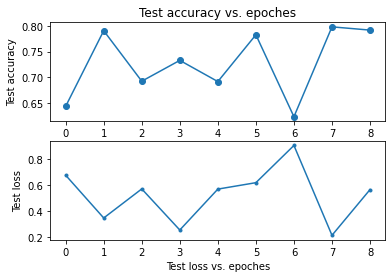

Mean accurancy on validation set is 0.727296
Mean loss on validation set is 0.523363


In [15]:
x1 = range(0, len(acc_list_val))
y1 = acc_list_val
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('Test accuracy vs. epoches')
plt.ylabel('Test accuracy')
x2 = range(0, len(acc_list_val))
y2 = np.array(loss_list_val)/4


plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('Test loss vs. epoches')
plt.ylabel('Test loss')
plt.show()
# 
mean_acc = np.sum(y1)/len(y1)
mean_loss = np.sum(y2)/len(y2)
print('Mean accurancy on validation set is {:2f}'.format(mean_acc))
print('Mean loss on validation set is {:2f}'.format(mean_loss))

## Conclusion
From single image training and test result, we validate the usability of the segnet. And we can see the model overfitted on single image and result "perfect" predicted mask.

For whole dataset training, we conducted 160 epochs. The trend of the learning curve and accuracy curve are plausible (one converges to the apparent error one improves overall), but still because our selection of the learning rate and varying image distributions the curves are with some fluctuations. 

For the validation part, we draw 8 mini batches from the validation set. The overall mean accuracy among all test batches turns to be 72.7%, comparing to the correspond value given in the paper is 61.9%, but that doesn't mean our result is well performed since the mean loss is not that low comparing to the overfitting single image loss. But by comparing the visualized results, we can manually check the real performance. The predicted mask and ground truth image are matched well, even same on a lot of detailed features. So my inference that the lower mean acc may be caused by some specific objects mis matching, e.g. in comparison images 3 and 4 the vehicle on the sideway are entirely not clustered at all.

There are still lots of improvements we can do on our reproduction project. Since we don’t have official source code, we implemented lots of functions ourselves, some of them are time and space inefficient, which boosts the training time epically when the image resolution is high. That’s also the reason we can’t eventually train on the full-size data. Secondly, we didn’t use advanced ML techniques in this project such as early stopping, varying learning rate and etc. But if those can be added we can see the pros and cons on using these methods. 

For illumination invariance image processing implementing those two image processing methods, the RGB images can be successfully transformed into illumination-invariant grayscale images. It can be concluded from the processed images that the influence of varying illumination has been eliminated. For example, the intensity of a whole wall in the gray image will keep consistent even though the wall has half of it covered by the shadow. Since the original RGB images have three channels as the input of the neural network, the processed grayscale images need to be repeated for three times to act as the three channels of the input to fit the pre-trained VGG16 network. As for the code, the image processing function serves as part of the transformation function. Once a batch of images were chosen to be trained or tested, they would be transformed into illumination-invariant images. Unfortunately, the processed images could not be trained successfully because the prediction array always kept being ‘nan’ from the first epoch for some unknown reasons, which caused back propagation impossible.

## Reference
1. G. D. Finlayson and S. D. Hordley, “Color constancy at a pixel,” Journal of the Optical Society of America. A, Optics, Image Science, and Vision, vol. 18, no. 2, pp. 253–264, 2001.
2. W. Maddern, A. Stewart, C. McManus, B. Upcroft, W. Churchill, and P. Newman, “Illumination invariant imaging: Applications in robust vision-based localisation, mapping and classification for autonomous vehicles,” in Proc. Int. Conf. on Robotics and Automation, vol. 2, 2014, p. 3.
3. J. A´ lvarez and A. Lopez, “Road detection based on illuminant invariance,” IEEE Trans. on Intelligent Transportation Systems, vol. 12, no. 1, pp. 184–193, 2011.
4. V. Badrinarayanan, A. Kendall, and R. Cipolla, “Segnet: A deep convolutional encoder-decoder architecture for image segmentation,” IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 39, no. 12, pp. 2481–2495, 2017.
5. K. Simonyan and A. Zisserman, “Very deep convolutional networks for large-scale image recognition,” CoRR, vol. abs/1409.1556, 2014.
6. A. Krizhevsky, I. Sutskever, and G. Hinton, “Imagenet classification with deep convolutional neural networks,” in Advances in Neural Information Processing Systems 25, 2012.
7. https://towardsdatascience.com/adam-latest-trends-in-deep-learning-optimization-6be9a291375c